# Text2Speech с использованием Tacotron2

Данная лабораторная работа описывает процесс преобразования текста в речь, используя предварительно обученную модель Tacotron2 в torchaudio.

Процесс преобразования текста в речь выглядит следующим образом:
* Предварительная обработка текста
* Генерация спектрограммы
* Преобразование спектрограммы в речь

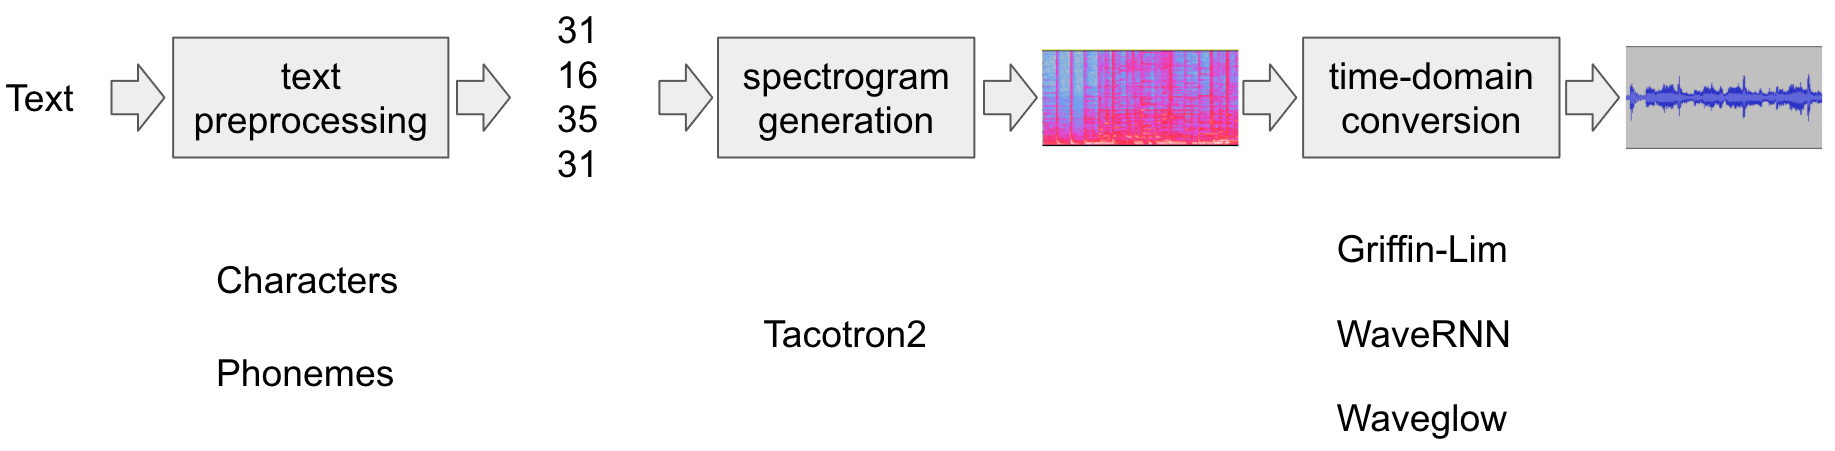

## Установка зависимостей  

Установим библиотеку DeepPhonemizer для выполнения кодирования на основе фонем

In [8]:
!pip install deep_phonemizer

  Using cached deep-phonemizer-0.0.19.tar.gz (29 kB)
  Preparing metadata (setup.py) ... done
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached Markdown-3.7-py3-none-any.whl.metadata (7.0 kB)
  Using cached protobuf-6.30.0-cp39-abi3-manylinux2014_x86_64.whl.metadata (593 bytes)
  Using cached tensorboard_data_server-0.7.2-py3-none-manylinux_2_31_x86_64.whl.metadata (1.1 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using cached tensorboard-2.19.0-py3-none-any.whl (5.5 MB)
Using cached absl_py-2.1.0-py3-none-any.whl (133 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 166.5 kB/s eta 0:00:00a 0:00:01
Using cached Markdown-3.7-py3-none-any.whl (106 kB)
Using cached protobuf-6.30.0-cp39-abi3-manylinux2014_x86_64.whl (316 kB)
Using cached tensorboard_d

In [1]:
import torch
import torchaudio

import IPython
import matplotlib.pyplot as plt

torch.random.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

print(torch.__version__)
print(torchaudio.__version__)
print(device)

2.5.1
2.5.1a0
cpu


## Предобработка обработка текста  

Сначала определяем набор символов -- `_-!\'(),.:;? abcdefghijklmnopqrstuvwxyz`. Затем сопоставляем каждый символ входного текста с индексом соответствующего символа в таблице. Символы, которых нет в таблице, игнорируются.

In [2]:
symbols = "_-!'(),.:;? abcdefghijklmnopqrstuvwxyz"
look_up = {s: i for i, s in enumerate(symbols)}
symbols = set(symbols)


def text_to_sequence(text):
    text = text.lower()
    return [look_up[s] for s in text if s in symbols]


text = "Hello! I am Tacotron2, awesome text to speech model! I was created by awesome researchers from various countries around world"
print(text_to_sequence(text))

[19, 16, 23, 23, 26, 2, 11, 20, 11, 12, 24, 11, 31, 12, 14, 26, 31, 29, 26, 25, 6, 11, 12, 34, 16, 30, 26, 24, 16, 11, 31, 16, 35, 31, 11, 31, 26, 11, 30, 27, 16, 16, 14, 19, 11, 24, 26, 15, 16, 23, 2, 11, 20, 11, 34, 12, 30, 11, 14, 29, 16, 12, 31, 16, 15, 11, 13, 36, 11, 12, 34, 16, 30, 26, 24, 16, 11, 29, 16, 30, 16, 12, 29, 14, 19, 16, 29, 30, 11, 17, 29, 26, 24, 11, 33, 12, 29, 20, 26, 32, 30, 11, 14, 26, 32, 25, 31, 29, 20, 16, 30, 11, 12, 29, 26, 32, 25, 15, 11, 34, 26, 29, 23, 15]


Таблица символов и индексы должны соответствовать тому, что ожидает предобученная модель Tacotron2. Библиотека `torchaudio` обеспечивает то же преобразование вместе с предобученной моделью

In [3]:
processor = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH.get_text_processor()

text = "Hello! I am Tacotron2, awesome text to speech model! I was created by awesome researchers from various countries around world"
processed, lengths = processor(text)

print(processed)
print(lengths)

tensor([[19, 16, 23, 23, 26,  2, 11, 20, 11, 12, 24, 11, 31, 12, 14, 26, 31, 29,
         26, 25,  6, 11, 12, 34, 16, 30, 26, 24, 16, 11, 31, 16, 35, 31, 11, 31,
         26, 11, 30, 27, 16, 16, 14, 19, 11, 24, 26, 15, 16, 23,  2, 11, 20, 11,
         34, 12, 30, 11, 14, 29, 16, 12, 31, 16, 15, 11, 13, 36, 11, 12, 34, 16,
         30, 26, 24, 16, 11, 29, 16, 30, 16, 12, 29, 14, 19, 16, 29, 30, 11, 17,
         29, 26, 24, 11, 33, 12, 29, 20, 26, 32, 30, 11, 14, 26, 32, 25, 31, 29,
         20, 16, 30, 11, 12, 29, 26, 32, 25, 15, 11, 34, 26, 29, 23, 15]])
tensor([124], dtype=torch.int32)


Промежуточное представление можно получить следующим образом:

In [4]:
print([processor.tokens[i] for i in processed[0, : lengths[0]]])

['h', 'e', 'l', 'l', 'o', '!', ' ', 'i', ' ', 'a', 'm', ' ', 't', 'a', 'c', 'o', 't', 'r', 'o', 'n', ',', ' ', 'a', 'w', 'e', 's', 'o', 'm', 'e', ' ', 't', 'e', 'x', 't', ' ', 't', 'o', ' ', 's', 'p', 'e', 'e', 'c', 'h', ' ', 'm', 'o', 'd', 'e', 'l', '!', ' ', 'i', ' ', 'w', 'a', 's', ' ', 'c', 'r', 'e', 'a', 't', 'e', 'd', ' ', 'b', 'y', ' ', 'a', 'w', 'e', 's', 'o', 'm', 'e', ' ', 'r', 'e', 's', 'e', 'a', 'r', 'c', 'h', 'e', 'r', 's', ' ', 'f', 'r', 'o', 'm', ' ', 'v', 'a', 'r', 'i', 'o', 'u', 's', ' ', 'c', 'o', 'u', 'n', 't', 'r', 'i', 'e', 's', ' ', 'a', 'r', 'o', 'u', 'n', 'd', ' ', 'w', 'o', 'r', 'l', 'd']


## Кодирование на основе фонем  

Кодирование на основе фонем похоже на кодирование на основе символов, но использует таблицу символов, основанную на фонемах, и модель G2P (графема-фонема).

Как и в случае кодирования на основе символов, ожидается, что процесс кодирования будет соответствовать тому, на чем обучалась предварительно обученная модель Tacotron2. Библиотека `torchaudio` имеет интерфейс для создания процесса.

Следующий код иллюстрирует, как создать и использовать этот процесс. Под катом модель G2P создается с использованием DeepPhonemizer

In [5]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()

text = "Hello! I am Tacotron2, awesome text to speech model! I was created by awesome researchers from various countries around world"
with torch.inference_mode():
    processed, lengths = processor(text)

print(processed)
print(lengths)

/home/nikita/anaconda3/envs/work/lib/python3.10/site-packages/dp/model/model.py:306: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, m

tensor([[54, 20, 65, 69,  2, 11, 32, 11, 16, 66, 11, 81, 16, 64, 20, 81, 78, 12,
         67,  6, 11, 24, 79, 20, 66, 11, 81, 40, 64, 79, 81, 11, 81, 20, 11, 79,
         77, 59, 37, 11, 66, 12, 38, 20, 65,  2, 11, 32, 11, 92, 12, 94, 11, 64,
         78, 59, 48, 81, 20, 38, 11, 36, 32, 11, 24, 79, 20, 66, 11, 78, 59, 79,
         44, 37, 44, 94, 11, 52, 78, 20, 66, 11, 91, 40, 78, 59, 20, 79, 11, 64,
         20, 67, 81, 78, 59, 94, 11, 44, 28, 67, 11, 92, 44, 65, 38]])
tensor([105], dtype=torch.int32)


В данном случае промежуточное представление выглядит следующим образом:

In [6]:
print([processor.tokens[i] for i in processed[0, : lengths[0]]])

['HH', 'AH', 'L', 'OW', '!', ' ', 'AY', ' ', 'AE', 'M', ' ', 'T', 'AE', 'K', 'AH', 'T', 'R', 'AA', 'N', ',', ' ', 'AO', 'S', 'AH', 'M', ' ', 'T', 'EH', 'K', 'S', 'T', ' ', 'T', 'AH', ' ', 'S', 'P', 'IY', 'CH', ' ', 'M', 'AA', 'D', 'AH', 'L', '!', ' ', 'AY', ' ', 'W', 'AA', 'Z', ' ', 'K', 'R', 'IY', 'EY', 'T', 'AH', 'D', ' ', 'B', 'AY', ' ', 'AO', 'S', 'AH', 'M', ' ', 'R', 'IY', 'S', 'ER', 'CH', 'ER', 'Z', ' ', 'F', 'R', 'AH', 'M', ' ', 'V', 'EH', 'R', 'IY', 'AH', 'S', ' ', 'K', 'AH', 'N', 'T', 'R', 'IY', 'Z', ' ', 'ER', 'AW', 'N', ' ', 'W', 'ER', 'L', 'D']


## Генерация спектрограммы  

`Tacotron2` -- это модель, которая используется для генерации спектрограммы из закодированного текста  

Код для данной процедуры представлен ниже

`Tacotron2.infer` использует полиномиальную выборку, поэтому процесс генерации спектрограммы носит случайный характер

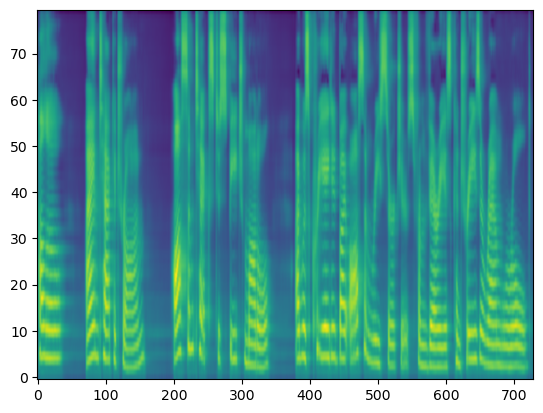

In [7]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)

text = "Hello! I am Tacotron2, awesome text to speech model! I was created by awesome researchers from various countries around world"

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, _, _ = tacotron2.infer(processed, lengths)


_ = plt.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")

torch.Size([80, 735])
torch.Size([80, 696])
torch.Size([80, 724])


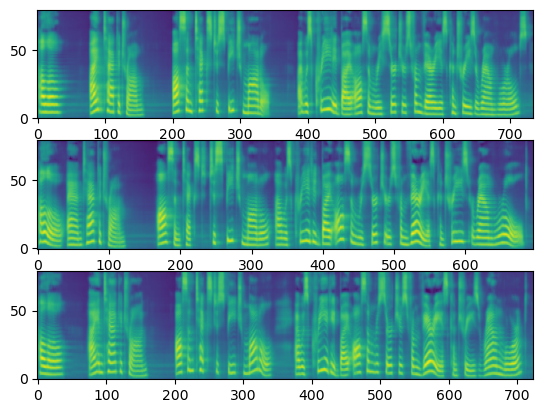

In [8]:
def plot():
    fig, ax = plt.subplots(3, 1)
    for i in range(3):
        with torch.inference_mode():
            spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
        print(spec[0].shape)
        ax[i].imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")


plot()

## Преобразование спектрограммы в речь

Последний шаг — восстановление речи  из спектрограммы с помощью вокодера.

`torchaudio` предоставляет вокодеры на основе `GriffinLim` и `WaveRNN`  

Пример с вокодером WaveRNN:

In [9]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

text = "Hello! I am Tacotron2, awesome text to speech model! I was created by awesome researchers from various countries around world"

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
    waveforms, lengths = vocoder(spec, spec_lengths)

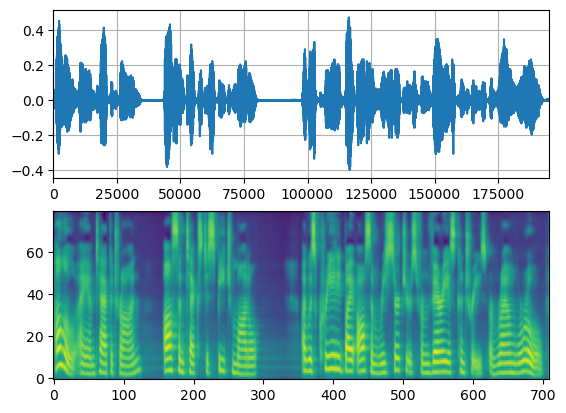

In [10]:
def plot(waveforms, spec, sample_rate):
    waveforms = waveforms.cpu().detach()

    fig, [ax1, ax2] = plt.subplots(2, 1)
    ax1.plot(waveforms[0])
    ax1.set_xlim(0, waveforms.size(-1))
    ax1.grid(True)
    ax2.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
    return IPython.display.Audio(waveforms[0:1], rate=sample_rate)


plot(waveforms, spec, vocoder.sample_rate)

Пример с вокодером GriffinLim:


Downloading: "https://download.pytorch.org/torchaudio/models/tacotron2_english_phonemes_1500_epochs_ljspeech.pth" to /home/nikita/.cache/torch/hub/checkpoints/tacotron2_english_phonemes_1500_epochs_ljspeech.pth
100.0%


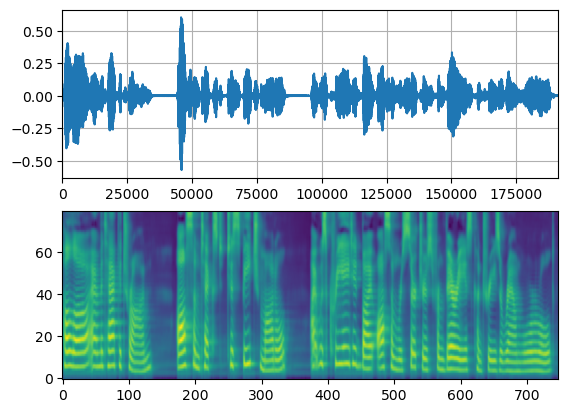

In [19]:
bundle = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
waveforms, lengths = vocoder(spec, spec_lengths)

plot(waveforms, spec, vocoder.sample_rate)

Пример с вокодером WaveGlow, разработанным в NVIDIA:

In [20]:
# Workaround to load model mapped on GPU
# https://stackoverflow.com/a/61840832
waveglow = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub",
    "nvidia_waveglow",
    model_math="fp32",
    pretrained=False,
)
checkpoint = torch.hub.load_state_dict_from_url(
    "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth",  # noqa: E501
    progress=False,
    map_location=device,
)
state_dict = {key.replace("module.", ""): value for key, value in checkpoint["state_dict"].items()}

waveglow.load_state_dict(state_dict)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()

with torch.no_grad():
    waveforms = waveglow.infer(spec)

plot(waveforms, spec, 22050)

/home/nikita/anaconda3/envs/work/lib/python3.10/site-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /home/nikita/.cache/torch/hub/torchhub.zip


KeyboardInterrupt: 

## Задание  

1. Попробуйте выполнить инференс Tacotron2 на любом другом предложении на английском языке. Преобразование спектрограммы в речь осуществить с помощью трех вокодеров: WaveRNN, GriffinLin и WaveGlow. Результаты генерации следует сохранить в виде отдельных аудиофайлов.

In [16]:
text = "Welcome to the future of artificial intelligence. My voice is synthesized, but my message is clear."

### WaveRNN

In [15]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)



with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
    waveforms, lengths = vocoder(spec, spec_lengths)

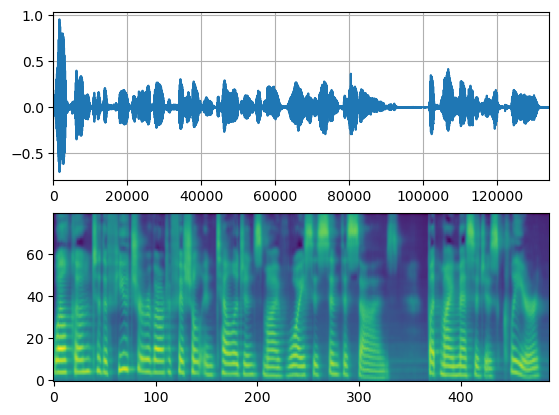

In [17]:
def plot(waveforms, spec, sample_rate):
    waveforms = waveforms.cpu().detach()

    fig, [ax1, ax2] = plt.subplots(2, 1)
    ax1.plot(waveforms[0])
    ax1.set_xlim(0, waveforms.size(-1))
    ax1.grid(True)
    ax2.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
    return IPython.display.Audio(waveforms[0:1], rate=sample_rate)


plot(waveforms, spec, vocoder.sample_rate)

In [18]:
from scipy.io import wavfile

sample_rate = vocoder.sample_rate
waveform = waveforms[0].cpu().numpy()
wavfile.write("output_speech1.wav", sample_rate, waveform)

### GriffinLin

/home/nikita/anaconda3/envs/work/lib/python3.10/site-packages/dp/model/model.py:306: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, m

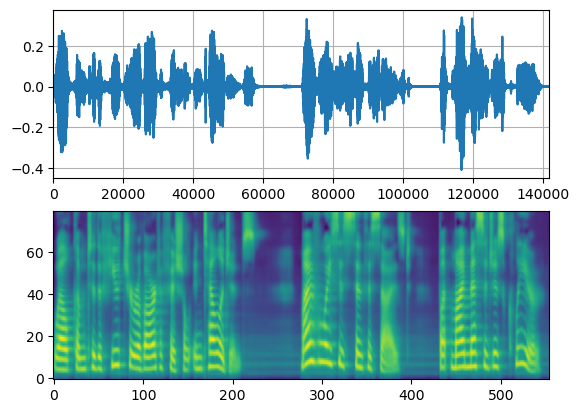

In [19]:
bundle = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
waveforms, lengths = vocoder(spec, spec_lengths)

plot(waveforms, spec, vocoder.sample_rate)

In [20]:
sample_rate = vocoder.sample_rate
waveform = waveforms[0].cpu().numpy()
wavfile.write("output_speech2.wav", sample_rate, waveform)

### WaveGlow

/home/nikita/anaconda3/envs/work/lib/python3.10/site-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /home/nikita/.cache/torch/hub/torchhub.zip
/home/nikita/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization w

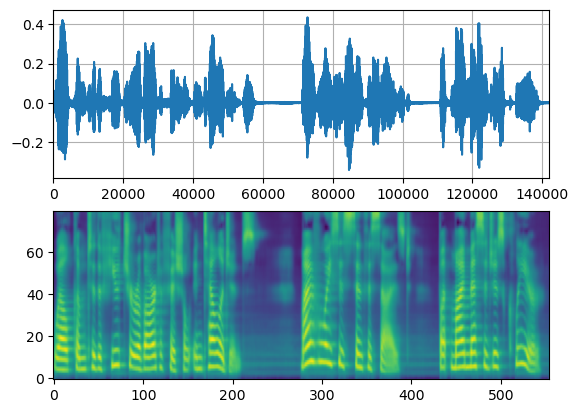

In [21]:
# Workaround to load model mapped on GPU
# https://stackoverflow.com/a/61840832
waveglow = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub",
    "nvidia_waveglow",
    model_math="fp32",
    pretrained=False,
)
checkpoint = torch.hub.load_state_dict_from_url(
    "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth",  # noqa: E501
    progress=False,
    map_location=device,
)
state_dict = {key.replace("module.", ""): value for key, value in checkpoint["state_dict"].items()}

waveglow.load_state_dict(state_dict)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()

with torch.no_grad():
    waveforms = waveglow.infer(spec)

plot(waveforms, spec, 22050)

In [22]:
sample_rate = vocoder.sample_rate
waveform = waveforms[0].cpu().numpy()
wavfile.write("output_speech3.wav", sample_rate, waveform)